In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def loadData(lang, filep = "./data_train.csv"):
    c = pd.read_csv(filep)
    c.fillna({"title":'',"abstract":''},inplace=True)
    c.dropna(inplace=True)
    for i,t,a in c[["title","abstract"]].itertuples():
        lang.addSentence(t+' '+a)
        
    return c

In [6]:
lang = Lang()
train = loadData(lang)
test = loadData(lang, "./data_test.csv")

In [7]:
train1 = train.sample(frac=0.8)
train2 = train.drop(train1.index)

In [8]:
label2int = {k : i for i,k in enumerate(train.label.unique())}
int2label = {v : k for k, v in label2int.items()}

In [9]:
len(lang.word2count)

6767

In [10]:
train.sample()

,pmid,year,title,abstract,label
80,22822591,2012,Abiraterone. After prostate cancer treatment f...,There is no standard treatment for metastatic ...,A1


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [12]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.out = nn.Sequential(*[nn.Linear(hidden_size, hidden_size) for i in range(n_layers-1)],nn.Linear(hidden_size, output_size))
        self.softmax = nn.LogSoftmax(dim=0)

    def forward(self, hidden):
        return self.softmax(self.out(hidden))

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    indexes.insert(0,SOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result

def variableFromLabel(label):
    result = Variable(torch.LongTensor([label2int[label]]))
    if use_cuda:
        return result.cuda()
    else:
        return result

In [14]:
def trainModel(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]

    loss = 0

    for ei in range(input_length):
        _, encoder_hidden = encoder(input_variable[ei], encoder_hidden)

    decoder_output = decoder(encoder_hidden[0][0]).unsqueeze(0)

    loss = criterion(decoder_output, target_variable)
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [74]:
def trainIters(train, test, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    plot_trainScore = []
    plot_testScore = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    scoreTrain, scoreTest = None, None

    for iter in range(1, n_iters + 1):
        sample = train.sample().iloc[0]
        input_variable = variableFromSentence(lang, sample.title)
        target_variable = variableFromLabel(sample.label)

        loss = trainModel(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            scoreTrain = score(train, encoder1, decoder1)
            scoreTest = score(test, encoder1, decoder1)
            print('%s (%d %d%%) %.4f %.2f %.2f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, scoreTrain, scoreTest))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            if scoreTrain :
                plot_trainScore.append(scoreTrain)
                plot_testScore.append(scoreTest)
                
            else :
                plot_trainScore.append(score(train, encoder, decoder))
                plot_testScore.append(score(test, encoder, decoder))
            plot_loss_total = 0
            scoreTrain, scoreTest = None, None

    showPlot(plot_losses)
    showPlot(list(zip(plot_trainScore,plot_testScore)))

In [75]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [76]:
def evaluate(encoder, decoder, sentence):
    input_variable = variableFromSentence(lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    for ei in range(input_length):
        _, encoder_hidden = encoder(input_variable[ei], encoder_hidden)

    decoder_output = decoder(encoder_hidden[0][0])

    return int2label[decoder_output.data.topk(1)[1][0]]

In [77]:
def evaluateRandomly(data, encoder, decoder, n=10):
    for i in range(n):
        sample = data.sample().iloc[0]
        inputSentence = sample.title
        target = sample.label
        print('>', inputSentence)
        print('=', target)
        output = evaluate(encoder, decoder, inputSentence)
        print('<', output)
        print('')

In [78]:
def score(data, encoder, decoder, n=1000):
    cpt = 0
    for i in range(n):
        sample = data.sample().iloc[0]
        inputSentence = sample.title
        target = sample.label
        output = evaluate(encoder, decoder, inputSentence)
        if output == target:
            cpt+=1
    return cpt/n

1m 3s (- 9m 32s) (100 10%) 1.1377 0.48 0.13
2m 2s (- 8m 11s) (200 20%) 1.0365 0.35 0.27
3m 1s (- 7m 3s) (300 30%) 1.0237 0.69 0.35
3m 59s (- 5m 59s) (400 40%) 0.9992 0.68 0.29
5m 2s (- 5m 2s) (500 50%) 0.8751 0.67 0.38
5m 51s (- 3m 54s) (600 60%) 0.8633 0.70 0.42
6m 40s (- 2m 51s) (700 70%) 0.7587 0.70 0.23
7m 37s (- 1m 54s) (800 80%) 0.6108 0.72 0.31
8m 36s (- 0m 57s) (900 90%) 0.5906 0.75 0.19
9m 39s (- 0m 0s) (1000 100%) 0.5721 0.78 0.28


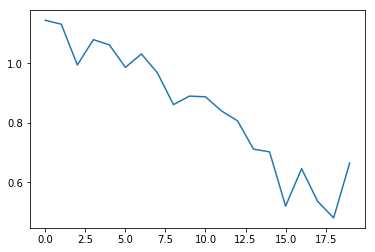

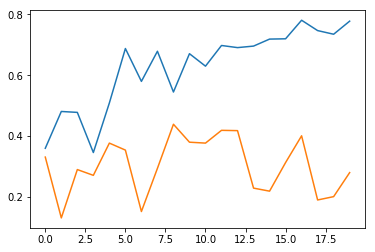

In [80]:
hidden_size = 256
encoder1 = EncoderRNN(lang.n_words, hidden_size)
decoder1 = Decoder(hidden_size,len(int2label))
ite = 1000

if use_cuda:
    encoder1 = encoder1.cuda()
    decoder1 = decoder1.cuda()

trainIters(train1, train2, encoder1, decoder1, ite, print_every=100, plot_every=50)

In [81]:
evaluateRandomly(train, encoder1, decoder1)

> TROPIC: Phase III trial of cabazitaxel for the treatment of metastatic castration-resistant prostate cancer.
= C2
< E3

> Perspectives on treatment of metastatic castration-resistant prostate cancer.
= C2
< E3

> Synthesis and structure-activity relationship studies of novel dihydropyridones as androgen receptor modulators.
= E3
< E3

> A profile of enzalutamide for the treatment of advanced castration resistant prostate cancer.
= E3
< E3

> [Roles of enzalutamide in castrate-resistant prostate cancer].
= E3
< A1

> Commentary on "AR-V7 and resistance to enzalutamide and abiraterone in prostate cancer." Antonarakis ES, Lu C, Wang H, Luber B, Nakazawa M, Roeser JC, Chen Y, Mohammad TA, Chen Y, Fedor HL, Lotan TL, Zheng Q, De Marzo AM, Isaacs JT, Isaacs WB, Nadal R, Paller CJ, Denmeade SR, Carducci MA, Eisenberger MA, Luo J, Division of Urologic Oncology, Department of Urology, University of Michigan, MI. N Engl J Med 2014; 371(11):1028-38.
= E3
< E3

> Preclinical Development of ONC1-

In [82]:
print(score(train1, encoder1, decoder1),score(train2, encoder1, decoder1))

0.783 0.267
